## Using the Pix2ix model to generate high quality images

Once our dataset is created we are ready to implement the model. The Pix2Pix code and info can be found in [this link](https://www.tensorflow.org/tutorials/generative/pix2pix), so you'll see that this code resembles the one showed there a lot. Let's begin by importing the libraries we are going to use and giving a last check to our dataset.

In [2]:
import os
import time
import numpy as np
from PIL import Image
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from tensorflow.keras.layers import *
from IPython.display import clear_output
from tensorflow.keras.models import Sequential, Model

target = '/content/drive/MyDrive/Data Mascotas/images/'
training = '/content/drive/MyDrive/Data Mascotas/training/'
checkpoints = '/content/drive/MyDrive/Data Mascotas/model_checkpoints/'
model_output = '/content/drive/MyDrive/Data Mascotas/model_outputs/'

In [3]:
!pip install -U tensorboard

Requirement already up-to-date: tensorboard in /usr/local/lib/python3.6/dist-packages (2.4.0)


We'll do this easily, we have two folders, one with the 'rotten' images (low resolution) and one with the target images (high resolution). The names of the images in the folders follow the same format, except for one little thing, in the target folder they have the name of the breed and a number, and in the rotten images they have **otten** at the beginning of the name.

In [4]:
path, dirs, files = next(os.walk(training))
rotten_count = len(files)

path, dirs, files = next(os.walk(target))
target_count = len(files)

if(target_count == rotten_count):
  print("All good to go!")

All good to go!


Let's take a look at some images to check the name format.

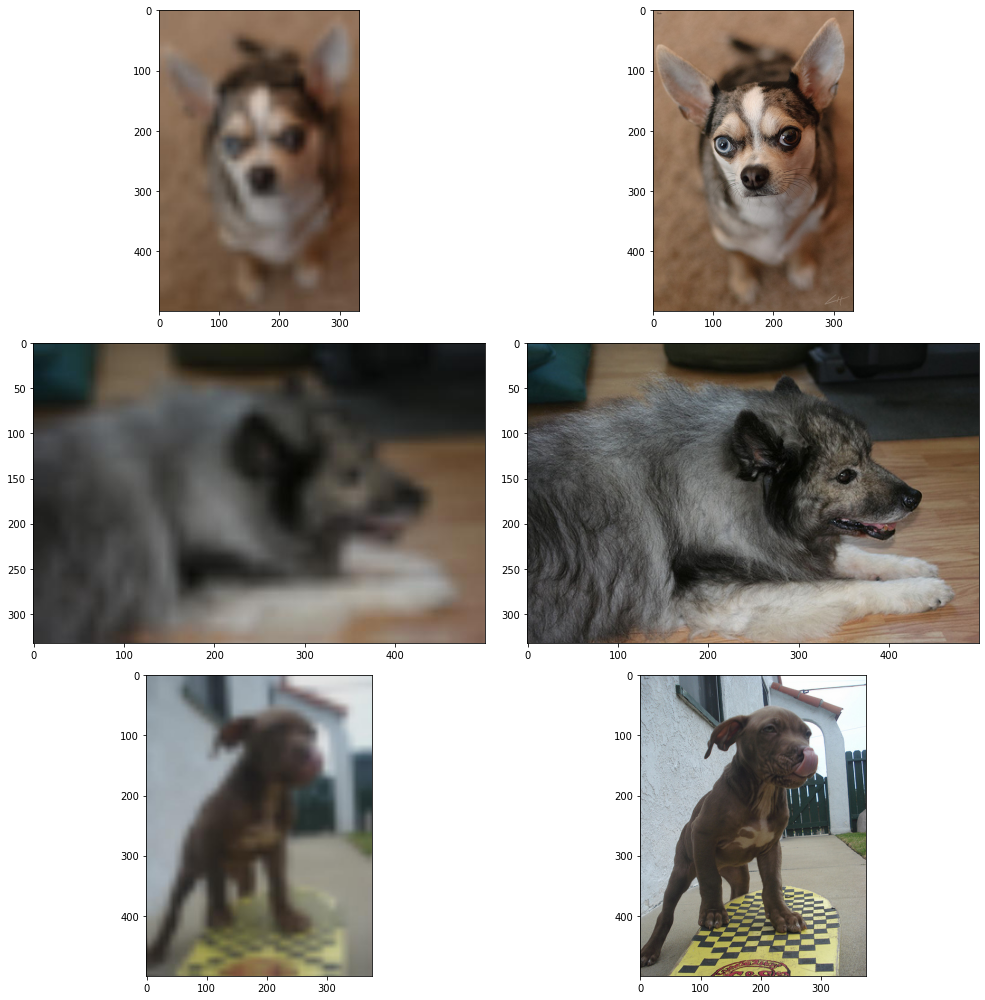

In [5]:
n_rows = 3
n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize = (14, 14))

for i in range(n_rows):
  index = np.random.randint(0, len(files) - 1)
  file_name = files[index]
        
  ax[i][0].imshow(Image.open(training + 'rotten' + file_name))
  ax[i][1].imshow(Image.open(target + file_name))

plt.tight_layout()
plt.show()

## Beginning the deep learning code

This part has no secret, we'll basically just follow the Pix2Pix paper and the recommended functions and way to code this functions presented on the Tensorflow page about Pix2Pix.

In [6]:
#n = 20
n = len(files)

train_n = round(n * 0.80)
randurls = np.copy(files)

print(randurls[:10])

np.random.seed(43)
np.random.shuffle(randurls)

print(randurls[:10])

train_urls = randurls[:train_n]
test_urls = randurls[train_n:n]

print("Training set length: ", len(train_urls))
print("Test set length: ", len(test_urls))

['Siamese_125.jpg' 'staffordshire_bull_terrier_97.jpg' 'Persian_44.jpg'
 'havanese_4.jpg' 'american_bulldog_109.jpg' 'boxer_104.jpg'
 'german_shorthaired_125.jpg' 'miniature_pinscher_98.jpg'
 'yorkshire_terrier_66.jpg' 'Egyptian_Mau_190.jpg']
['miniature_pinscher_45.jpg' 'german_shorthaired_116.jpg'
 'wheaten_terrier_31.jpg' 'Bengal_92.jpg' 'great_pyrenees_91.jpg'
 'american_bulldog_171.jpg' 'Russian_Blue_110.jpg' 'Maine_Coon_213.jpg'
 'wheaten_terrier_5.jpg' 'saint_bernard_161.jpg']
Training set length:  5350
Test set length:  1338


In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

def resize(inimg, tgimg, height, width):
  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])

  return inimg, tgimg

def normalize(inimg, tgimg):
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1

  return inimg, tgimg

def random_jitter(inimg, tgimg):
  inimg, tgimg = resize(inimg, tgimg, 286, 286)

  stacked_image = tf.stack([inimg, tgimg], axis = 0)
  cropped_image = tf.image.random_crop(stacked_image, size = [2, IMG_HEIGHT, IMG_WIDTH, 3])

  inimg, tgimg = cropped_image[0], cropped_image[1]

  if(np.random.uniform() > 0.5):
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  return inimg, tgimg

def load_image(filename, augment = True):
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(training + 'rotten' + filename)), tf.float32)[..., :3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(target + filename)), tf.float32)[..., :3]

  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)

  if(augment):
    inimg, tgimg = random_jitter(inimg, tgimg)
  
  inimg, tgimg = normalize(inimg, tgimg)

  return inimg, tgimg

def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)

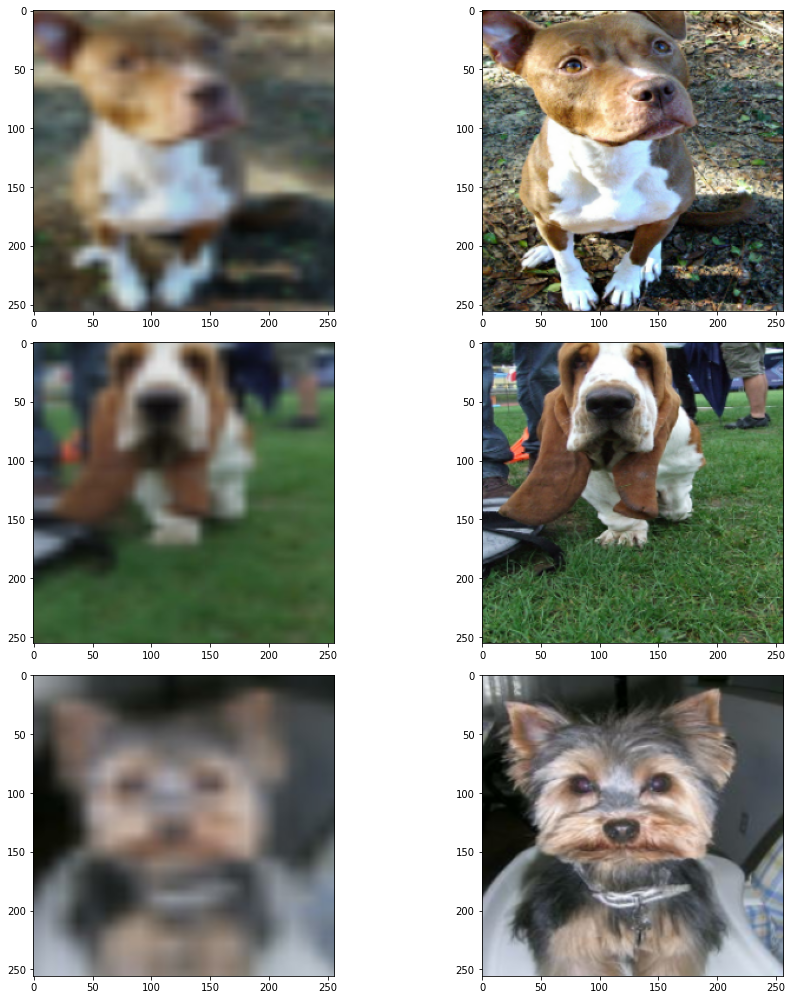

In [8]:
n_rows = 3
n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize = (14, 14))

for i in range(n_rows):
  index = np.random.randint(0, len(files) - 1)
  images = load_train_image(files[index])
        
  ax[i][0].imshow((images[0] + 1) / 2)
  ax[i][1].imshow((images[1] + 1) / 2)

plt.tight_layout()
plt.show()

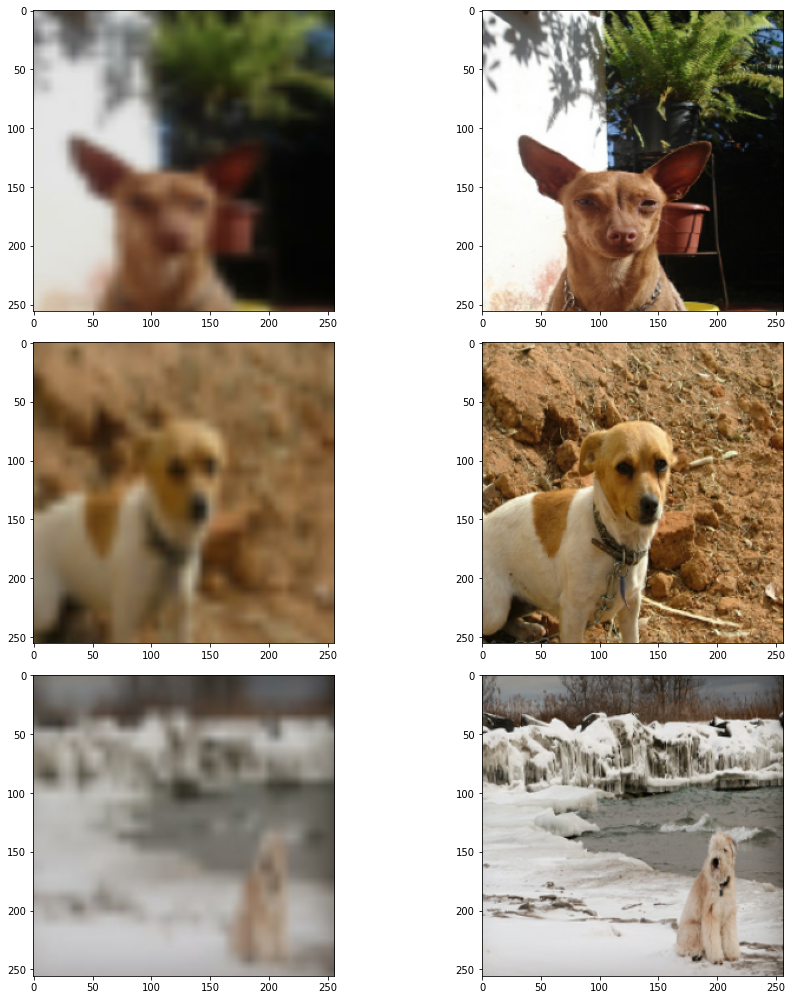

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(test_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

n_rows = 3
n_cols = 2
aux = 0

fig, ax = plt.subplots(n_rows, n_cols, figsize = (14, 14))

for inimg, tgimg in train_dataset.take(n_rows):
        
  ax[aux][0].imshow((inimg[0, ...] + 1) / 2)
  ax[aux][1].imshow((tgimg[0, ...] + 1) / 2)
  aux += 1

plt.tight_layout()
plt.show()

In [10]:
def downsample(filters, apply_batchnorm = True):

  result = Sequential()

  initializer = tf.random_normal_initializer(0, 0.02)

  result.add(Conv2D(filters,
                    kernel_size = (4, 4),
                    strides = 2,
                    padding = 'same',
                    kernel_initializer = initializer,
                    use_bias = not apply_batchnorm))
  
  if(apply_batchnorm):
    result.add(BatchNormalization())
  
  result.add(LeakyReLU())

  return result

In [11]:
def upsample(filters, apply_dropout = False):

  result = Sequential()

  initializer = tf.random_normal_initializer(0, 0.02)

  result.add(Conv2DTranspose(filters,
                             kernel_size = (4, 4),
                             strides = 2,
                             padding = 'same',
                             kernel_initializer = initializer,
                             use_bias = False))
  
  result.add(BatchNormalization())

  if(apply_dropout):
    result.add(Dropout(0.5))

  result.add(ReLU())

  return result

In [12]:
def Generator():
  inputs = tf.keras.layers.Input(shape = [None, None, 3])

  down_stack = [
    downsample(64, apply_batchnorm = False),
    downsample(128),
    downsample(256),
    downsample(512),
    downsample(512),
    downsample(512),
    downsample(512),
    downsample(512)
  ]

  up_stack = [
    upsample(512, apply_dropout = True),
    upsample(512, apply_dropout = True),
    upsample(512, apply_dropout = True),
    upsample(512),
    upsample(256),
    upsample(128),
    upsample(64),
  ]

  initializer = tf.random_normal_initializer(0, 0.02)

  last = Conv2DTranspose(filters = 3,
                         kernel_size = (4, 4),
                         strides = 2,
                         padding = 'same',
                         kernel_initializer = initializer,
                         activation = 'tanh')

  x = inputs
  s = []

  concat = Concatenate()

  for down in down_stack:
    x = down(x)
    s.append(x)

  s.pop()
  for up in up_stack:
    x = up(x)
    x = concat([x, s.pop()])
  
  last = last(x)
  return Model(inputs = inputs, outputs = last)

In [13]:
def Discriminator():

  ini = Input(shape = [None, None, 3], name = 'input_img')
  gen = Input(shape = [None, None, 3], name = 'gener_img')

  con = concatenate([ini, gen])

  initializer = tf.random_normal_initializer(0, 0.02)

  down1 = downsample(64, apply_batchnorm = False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)

  last = Conv2D(filters = 1,
                kernel_size = (4, 4),
                strides = 1,
                kernel_initializer = initializer,
                padding = 'same')(down4)

  return Model(inputs = [ini, gen], outputs = last)  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


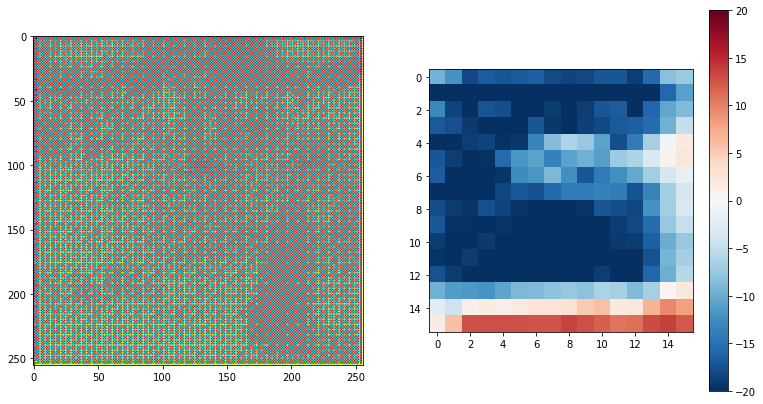

In [14]:
generator = Generator()
gen_output = generator(((inimg + 1) * 255), training = False)

discriminator = Discriminator()
disc_out = discriminator([((inimg + 1) * 255), gen_output], training = False)
disc_out.shape

fig, ax = plt.subplots(ncols = 2, figsize = (13, 7))

ax[0].imshow(gen_output[0, ...])
a = ax[1].imshow(disc_out[0, ..., -1], vmin = -20, vmax = 20, cmap = 'RdBu_r')

fig.colorbar(a)
plt.show()

In [15]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [16]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [17]:
LAMBDA = 100

def generator_loss(disc_generator_output, gen_output, target):

  gan_loss = loss_object(tf.ones_like(disc_generator_output), disc_generator_output)

  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

checkpoint_prefix = os.path.join(checkpoints, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

checkpoint.restore(tf.train.latest_checkpoint(checkpoints)).assert_existing_objects_matched()

In [19]:
def generate_images(model, test_input, tar, save_filename = False, display_imgs = False):

  prediction = model(test_input, training = True)

  if(save_filename):
    tf.keras.preprocessing.image.save_img(model_output + save_filename + '.jpg', prediction[0, ...])

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if(display_imgs):      
    plt.figure(figsize = (10, 10))
    fig, ax = plt.subplots(ncols = 3, figsize = (13, 13))      
      
    ax[0].imshow(display_list[0] * 0.5 + 0.5)
    ax[0].set_title(title[0])
    ax[0].axis('off')

    ax[1].imshow(display_list[1] * 0.5 + 0.5)
    ax[1].set_title(title[1])
    ax[1].axis('off')

    ax[2].imshow(display_list[2] * 0.5 + 0.5)
    ax[2].set_title(title[2])
    ax[2].axis('off')
      
    plt.show()

In [40]:
@tf.function()
def train_step(input_image, target):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    output_image = generator(input_image, training = True)
    output_gen_disc = discriminator([output_image, input_image], training = True)
    output_trg_disc = discriminator([target, input_image], training = True)
    disc_loss = discriminator_loss(output_trg_disc, output_gen_disc)
    gen_loss = generator_loss(output_gen_disc, output_image, target)

    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

In [69]:
def train(dataset, epochs):
  for epoch in range(epochs):

    imgi = 0   
    for input_image, target in dataset:
      print('epoch: ' + str(epoch) + ' - train ' + str(imgi) + '/' + str(len(train_urls)))
      imgi += 1
      train_step(input_image, target)
    
      clear_output(wait = True)

    img = 0
    for inp, tar in test_dataset.take(5):
      
      generate_images(generator, inp, tar, str(imgi + 75) + '_' + str(epoch), display_imgs = True)
      imgi += 1

    if((epoch + 1) % 25 == 0):
      checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
train(train_dataset, 25)

<Figure size 720x720 with 0 Axes>

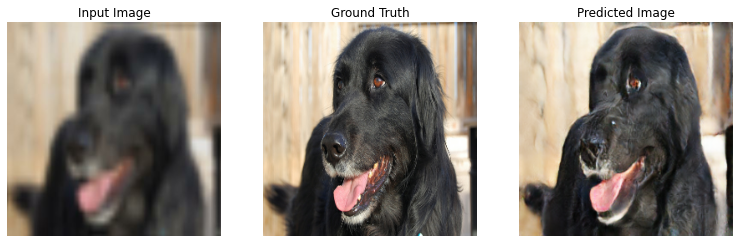

In [37]:
for inp, tar in test_dataset.shuffle(90).take(1):
  generate_images(generator, inp, tar, 'test', display_imgs = True)